In [0]:
!pip install tensorflow==2.0.0b1
!pip install SimpleITK
import tensorflow as tf
assert tf.__version__=='2.0.0-beta1'
# DON'T use the magic %tensorflow_version 2.0, it will load the stable version which could alter the model output.

from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython import display
import time
import math
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('./drive/My Drive/Segmentation')

print(tf.__version__)

from google.colab import drive
drive.mount('/content/drive')

In [0]:
BATCH_SIZE = 128
mods = ['MR_Flair_mri', 'pix2pix_Flair_mri', 'MIpix2pix_Flair_mri', 'MIGAN_Flair_mri', 'OT_mri']


# PROCESSING IMAGES IN THE BATCH
def process_batch(batch):   # takes in input a raw_record[mod].numpy()
    batch = tf.io.decode_raw(batch, tf.float32)
    batch = tf.reshape(batch, (1, 256, 256))
    batch = tf.squeeze(batch)
    batch = tf.expand_dims(batch, axis=2)
    return batch

def retrieve_dataset(dataset_dir, shuffle=False, shuffle_buffer=128):
    dataset = tf.data.TFRecordDataset(dataset_dir)
    # Create a dictionary describing the features.
    image_feature_description = {
        mods[0]: tf.io.FixedLenFeature([], tf.string),
        mods[1]: tf.io.FixedLenFeature([], tf.string),
        mods[2]: tf.io.FixedLenFeature([], tf.string),
        mods[3]: tf.io.FixedLenFeature([], tf.string),
        mods[4]: tf.io.FixedLenFeature([], tf.string),
    }
    def _parse_image_function(example_proto):
    # Parse the input tf.Example proto using the dictionary above.
        parsed = tf.io.parse_single_example(example_proto, image_feature_description)
        batch0 = process_batch(parsed[mods[0]])
        batch1 = process_batch(parsed[mods[1]])
        batch2 = process_batch(parsed[mods[2]])
        batch3 = process_batch(parsed[mods[3]])
        batch4 = process_batch(parsed[mods[4]])
        return batch0, batch1, batch2, batch3, batch4

    dataset = dataset.shuffle(shuffle_buffer, seed=1234567890, reshuffle_each_iteration=True) if shuffle else dataset
    dataset = dataset.map(_parse_image_function)
    dataset = dataset.batch(BATCH_SIZE) if BATCH_SIZE > 0 else dataset
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

def plot_images(*args): 
    
    if len(args) == 5:
        display_list = [args[0], args[1], args[2], args[3], args[4]]   # input, gt, prediction, gt masked, pred masked
        title = ['$\mathit{T_{2flair}}$', 'Pred p2p', 'Pred MI-p2p', 'Pred MI-GAN', 'Ground Truth']
        figsize = (14, 7)
    elif len(args) == 3:
        display_list = [args[0], args[1], args[2]]   # input, gt and prediction
        title = [r'$\it{T_{2flair}}$', r'$\it{Ground\ Truth}$', r'$\it{Segmentation}$']
        figsize = (10, 5)
    elif len(args) == 9:
        display_list = [args[0], args[1], args[2], args[3], args[4], args[5], args[6], args[7], args[8]]
        title = [r'${T_{2flair}}$', r'$\it{Pred\ p2p}$', r'$\it{Pred\ MI-p2p}$', r'$\it{Pred\ MI-GAN}$', r'$\it{Ground\ Truth}$', r'$\it{Segmentation}$', r'$\it{Segm.\ p2p}$', r'$\it{Segm.\ MI-p2p}$', r'$\it{Segm.\ MI-GAN}$']
       
        figsize = (23, 12)
    plt.figure(1 , figsize)
    n = 0
    for i in range(len(args)):    # batch size is different from 10, but let's show just 10 images.
        n += 1
        plt.subplot(1, len(args), n).title.set_text(title[i])
        plt.subplot(1, len(args), n).title.set_size(16)
        plt.imshow(tf.squeeze(display_list[i]), cmap='bone')
        plt.axis('off')
    plt.subplots_adjust(left=0, bottom=None, right=0.75, top=None, wspace=0.0, hspace=None)
    plt.show()

In [0]:
generated_dataset = retrieve_dataset('./drive/My Drive/Segmentation/generated_testing_mri.tfrecords', shuffle=True, shuffle_buffer=3584)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
from DeepMRI import DeepMRI
import SegAN_IO_arch as arch

model_name = 'Segan_IO_TF2_brats_on_FLAIR' # The name of the folder inside './models' containing the model to load
mri_channels = 1 # input channels (modalities)

gan = DeepMRI(batch_size=BATCH_SIZE, size=256, mri_channels=mri_channels, model_name=model_name)
gan.build_model(load_model='last', seed=1234567890, arch=arch)

No GPU found, model running on CPU
No GPU found, model running on CPU
Using architecture: SegAN_IO_arch
Latest Checkpoint is: ./drive/My Drive/Segmentation/models/Segan_IO_TF2_brats_on_FLAIR/best_dice_score_168-29
Loaded model from: last, next epoch: 169


In [0]:
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_dataset.take(1):
    segmentation = gan.generator(tflair, training=False)
    #segm_p2p_pred = gan.generator(p2p_pred, training=False)
    #segm_mip2p_pred = gan.generator(mip2p_pred, training=False)
    #segm_migan_pred = gan.generator(migan_pred, training=False)

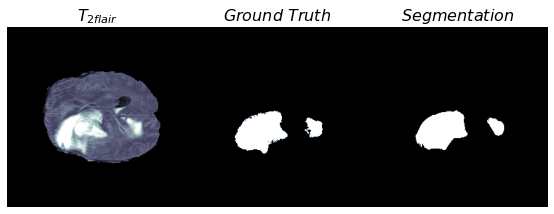

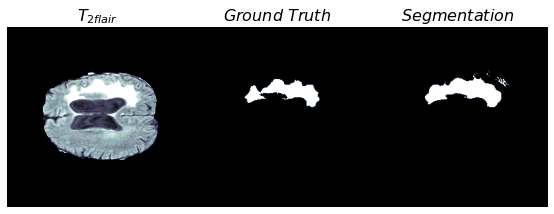

In [0]:
for i in range(64):
    if i in [9, 16]:
        plot_images(tflair[i], gt[i], segmentation[i])

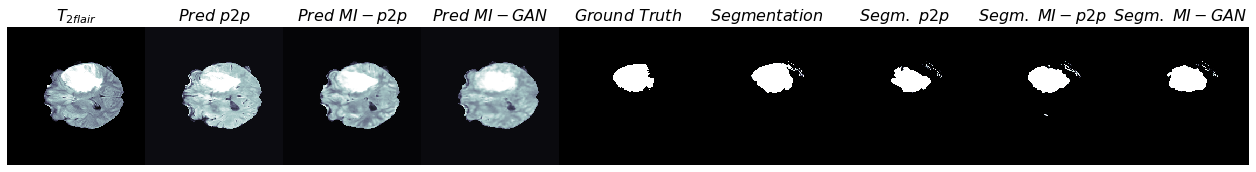

In [0]:
idx = 0
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_dataset.take(3):

    segmentation = gan.generator(tflair, training=False)
    segm_p2p_pred = gan.generator(p2p_pred, training=False)
    segm_mip2p_pred = gan.generator(mip2p_pred, training=False)
    segm_migan_pred = gan.generator(migan_pred, training=False)
    if idx == 2:
         plot_images_new(tflair, p2p_pred, mip2p_pred, migan_pred, gt, segmentation, segm_p2p_pred, segm_mip2p_pred, segm_migan_pred)
    idx += 1

# Compute DICE score

In [0]:
def compute_metrics(y_true, y_pred, threshold=0.5):
      # Boolean segmentation outputs
    # Condition Positive - real positive cases
    CP = tf.greater(y_true, threshold)  # Ground truth
    # Predicted Condition Positive - predicted positive cases
    PCP = tf.greater(y_pred, threshold)   # Segmentation from S (prediction)
    # Codition Negative
    CN = tf.math.logical_not(CP)
    # Predicted Condition Negative
    PCN = tf.math.logical_not(PCP)
    TP = tf.math.count_nonzero(tf.math.logical_and(CP, PCP), axis=(1, 2))
    FP = tf.math.count_nonzero(tf.math.logical_and(CN, PCP), axis=(1, 2))
    FN = tf.math.count_nonzero(tf.math.logical_and(CP, PCN), axis=(1, 2))
    TN = tf.math.count_nonzero(tf.math.logical_and(CN, PCN), axis=(1, 2))

    return TP, FP, FN, TN

In [0]:
from DeepMRI import DeepMRI
import SegAN_IO_arch as arch

model_name = 'Segan_IO_TF2_brats_on_FLAIR' # The name of the folder inside './models' containing the model to load
mri_channels = 1 # input channels (modalities)

gan = DeepMRI(batch_size=BATCH_SIZE, size=256, mri_channels=mri_channels, model_name=model_name)
gan.build_model(load_model='last', seed=1234567890, arch=arch)

No GPU found, model running on CPU
No GPU found, model running on CPU
Using architecture: SegAN_IO_arch
Latest Checkpoint is: ./drive/My Drive/Segmentation/models/Segan_IO_TF2_brats_on_FLAIR/best_dice_score_168-29
Loaded model from: last, next epoch: 169


In [0]:
generated_dataset = retrieve_dataset('./drive/My Drive/Segmentation/generated_testing_mri.tfrecords', shuffle=False, shuffle_buffer=3584)

In [0]:
container_dice = tf.TensorArray(tf.float64, size=28)    # 28 is the number of volumes in the testing set

idx = 0
for tflair, p2p_pred, mip2p_pred, migan_pred, gt in generated_dataset.take(28):
    #print(tflair.shape)
    print(idx)
    #segmentation_tflair = gan.generator(tflair, training=False)
    #segm_p2p_pred = gan.generator(p2p_pred, training=False)
    segm_mip2p_pred = gan.generator(mip2p_pred, training=False)
    #segm_migan_pred = gan.generator(migan_pred, training=False)

    #tf.math.count_nonzero
    TP, FP, FN, TN = compute_metrics(gt, segm_mip2p_pred)

    FP_np = FP.numpy()
    index = 0

    for i in gt:
        if tf.math.equal((tf.math.count_nonzero(i)), 0):
            FP_np[index] = 0       # set to zero all the FP in a volume where the ground truth is a black image.
        index += 1

    TP_volume = tf.reduce_sum(TP)
    FP_volume = tf.reduce_sum(FP_np)
    FN_volume = tf.reduce_sum(FN)
    TN_volume = tf.reduce_sum(TN)
    dice_score = tf.where(tf.greater(TP_volume+FP_volume+FN_volume, 0), (2*TP_volume)/(2*TP_volume+FP_volume+FN_volume), 1.0)
    container_dice = container_dice.write(idx, dice_score)

    idx += 1
container_dice = container_dice.stack()

In [0]:
print(container_dice)

mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and mip2p: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

# DICE score on (gt, T2flair)


Using 256x256: 0.8053 ± 0.1156

Using 160x160: 0.8040 ± 0.1144

In [0]:
print(container_dice)

mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and tflair: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

tf.Tensor(
[0.88053779 0.80952381 0.88572343 0.7726957  0.7838443  0.8888017
 0.90575967 0.72433678 0.84575416 0.8905769  0.84992927 0.74051336
 0.86359954 0.90538777 0.74861702 0.59589458 0.78174928 0.78482449
 0.87573773 0.90919536 0.75852402 0.8376274  0.85285687 0.3592787
 0.72662323 0.72914537 0.89477116 0.94796917], shape=(28,), dtype=float64)
DICE score over gt and tflair: 0.8053 ± 0.1156


# Without normalization of the predictions

## DICE score on (gt, MIp2p)

In [0]:
container_dice

<tf.Tensor: id=31644, shape=(28,), dtype=float64, numpy=
array([0.87460226, 0.76362472, 0.89266072, 0.7177674 , 0.72653416,
       0.78039481, 0.87955379, 0.85870367, 0.79884851, 0.84184278,
       0.87068316, 0.72449003, 0.83106582, 0.88012152, 0.74315176,
       0.73840445, 0.8485346 , 0.01907211, 0.86186972, 0.83988953,
       0.7227646 , 0.69291897, 0.79196387, 0.53073934, 0.89198654,
       0.74146877, 0.48934611, 0.44192931])>

In [0]:
mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and mip2p: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

DICE score over gt and mip2p: 0.7427 ± 0.1810


## DICE score on (gt, MIGAN)

In [0]:
container_dice

<tf.Tensor: id=37573, shape=(28,), dtype=float64, numpy=
array([0.85090396, 0.78219715, 0.86677202, 0.73130863, 0.67839117,
       0.79347185, 0.8755578 , 0.86695871, 0.57193923, 0.82026984,
       0.8436284 , 0.68455751, 0.81285466, 0.85230818, 0.72052782,
       0.63006469, 0.7512054 , 0.11454935, 0.83217246, 0.80383625,
       0.64549423, 0.67601688, 0.69373388, 0.50582892, 0.87143883,
       0.5102204 , 0.32405616, 0.03371504])>

In [0]:
mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and migan: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

DICE score over gt and migan: 0.6837 ± 0.2136


## DICE score on (gt, p2p)


In [0]:
container_dice

<tf.Tensor: id=43502, shape=(28,), dtype=float64, numpy=
array([0.73326679, 0.7916377 , 0.8376503 , 0.70001936, 0.55990326,
       0.64581554, 0.81915918, 0.87337315, 0.38066739, 0.74247597,
       0.81079871, 0.70648231, 0.74862595, 0.69376344, 0.67721907,
       0.64943189, 0.781232  , 0.29570093, 0.76453006, 0.79639912,
       0.48999475, 0.59077174, 0.62059741, 0.44956978, 0.91015224,
       0.6549228 , 0.28713529, 0.55953455])>

In [0]:
mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and p2p: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

DICE score over gt and p2p: 0.6632 ± 0.1608


# With normalization of the predictions

## DICE score on (gt, MIp2p)


In [0]:
container_dice

<tf.Tensor: id=19719, shape=(28,), dtype=float64, numpy=
array([0.88198419, 0.77027499, 0.8938637 , 0.694699  , 0.69546011,
       0.77286119, 0.88401569, 0.86177798, 0.73995673, 0.84726292,
       0.86954395, 0.69517481, 0.78243309, 0.88736341, 0.71465382,
       0.7362865 , 0.8619654 , 0.01006728, 0.86250806, 0.80916824,
       0.70060064, 0.69731765, 0.7908579 , 0.5257099 , 0.89007341,
       0.74004269, 0.3959619 , 0.4246494 ])>

In [0]:
mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and t2flair: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

DICE score over gt and t2flair: 0.7299 ± 0.1887


## DICE score on (gt, MIGAN)

In [0]:
container_dice

<tf.Tensor: id=25648, shape=(28,), dtype=float64, numpy=
array([0.85538593, 0.77249052, 0.86899342, 0.70589565, 0.62153375,
       0.78455406, 0.87824552, 0.86610122, 0.49031474, 0.82899991,
       0.83403426, 0.649532  , 0.79222328, 0.86590943, 0.70837154,
       0.62268291, 0.7516074 , 0.12076734, 0.83352452, 0.76525154,
       0.62105848, 0.68337575, 0.68530644, 0.4852812 , 0.85630764,
       0.47614489, 0.22451739, 0.02477787])>

In [0]:
mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and migan: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

DICE score over gt and migan: 0.6669 ± 0.2230


## DICE score on (gt, p2p)


In [0]:
container_dice

<tf.Tensor: id=13790, shape=(28,), dtype=float64, numpy=
array([0.75928522, 0.78851789, 0.85249311, 0.67661334, 0.50759392,
       0.60702578, 0.82140702, 0.89165958, 0.30447626, 0.7625636 ,
       0.80853999, 0.64723085, 0.69426069, 0.69900598, 0.64931748,
       0.64160358, 0.8009805 , 0.42146642, 0.76008735, 0.7387321 ,
       0.55112124, 0.64175358, 0.60353996, 0.41266552, 0.89112252,
       0.60599441, 0.15149178, 0.27374465])>

In [0]:
mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and t2flair: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

DICE score over gt and t2flair: 0.6416 ± 0.1848


# With percentiles normalization of the predictions

## DICE score on (gt, mip2p)



In [0]:
print(container_dice)

mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and mip2p: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

tf.Tensor(
[0.78326773 0.58467534 0.65873188 0.57096129 0.77514061 0.52945723
 0.8500253  0.69198775 0.5397469  0.80258518 0.87260101 0.56933825
 0.74828612 0.70074805 0.4691462  0.85292472 0.86268747 0.31668003
 0.87993466 0.71582344 0.75237888 0.74959867 0.82930426 0.6360773
 0.82516454 0.33658388 0.36780611 0.25694267], shape=(28,), dtype=float64)
DICE score over gt and mip2p: 0.6617 ± 0.1796


## DICE score on (gt, migan)



In [0]:
print(container_dice)

mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and migan: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

tf.Tensor(
[0.79307568 0.61054935 0.55273914 0.57623986 0.72895002 0.49573261
 0.84312292 0.62667637 0.34134988 0.80471552 0.86393173 0.53688661
 0.75298484 0.65164821 0.41450613 0.80761802 0.8235148  0.32524679
 0.86197186 0.70681439 0.63805613 0.70803437 0.80584187 0.61974479
 0.78432089 0.21441903 0.29909907 0.07547695], shape=(28,), dtype=float64)
DICE score over gt and migan: 0.6165 ± 0.2084


## DICE score on (gt, p2p)

In [0]:
print(container_dice)

mean = tf.reduce_mean(container_dice)
std = tf.math.reduce_std(container_dice)
print("DICE score over gt and p2p: {} ± {}".format((f'{mean:.4f}'), (f'{std:.4f}')))

tf.Tensor(
[0.81189198 0.70030454 0.69352204 0.66701054 0.75425281 0.54884399
 0.83786643 0.72838986 0.28606134 0.77453772 0.82565491 0.58400541
 0.75812249 0.69006158 0.52016016 0.77689787 0.80889926 0.44336339
 0.84789381 0.77553061 0.65979313 0.67415322 0.79715022 0.63236843
 0.87035727 0.39238609 0.33623918 0.59424247], shape=(28,), dtype=float64)
DICE score over gt and p2p: 0.6711 ± 0.1550
